# validation data 합치기(macc, m_usage_stats 빼고)

## val 데이터 불러오기


In [1]:
import os
import pandas as pd
import numpy as np
# 데이터 세트의 저장 위치 설정
challenge2024_dataset_path = "/Users/aswm0121/Downloads/휴먼이해2024"
challenge2024_dataset_path1 = "/Users/aswm0121/Downloads/휴먼이해2024/val dataset"
challenge2024_dataset_path2 = "/Users/aswm0121/Downloads/휴먼이해2024/test dataset"


## mActivity
1일 평균을 구하는 대신 **하루동안 각 활동을 몇 번 했는지 카운팅**해주었다.
결과적으로 **105 row의 dataframe으로 합치는 데 성공**
> 스마트폰에서 인식된 행동 분류값. **1분마다 1회씩** 기록됨.
  
- subject_id: 실험 참여자의 식별자
- timestamp
- m_activity
- 0: IN_VEHICLE
- 1: ON_BICYCLE
- 2: ON_FOOT
- 3: STILL
- 4: UNKNOWN
- 5: TILTING
- 7: WALKING
- 8: RUNNING
  

  

In [2]:
# 파일 불러오기
file_name = "ch2024_test_m_activity.parquet.gzip"
df_mact = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))


# 년 월 달 의 정보만 가지고 있는 컬럼 생성(날짜별로 묶어주기 위해)
df_mact['Date'] = pd.to_datetime(df_mact['timestamp'], format='%Y-%m-%d').dt.date

# 기존의 timestamp 컬럼 삭제한다
df_mact.drop(columns = 'timestamp', axis = 1, inplace = True)
#df_mact

# subject_id, Date로 묶어서 활동을 총 몇 번 했는지 알려주는 컬럼 생성
df_new = df_mact.groupby(['subject_id', 'Date'])['m_activity'].count().reset_index()
#df_new

# subject_id, Date로 묶어준다음 0~8번 활동을 하루에 각각 몇 번씩 했는지 알기 위해 groupby 사용
activity_count = df_mact.groupby(['subject_id', 'Date'])['m_activity'].value_counts().unstack(fill_value=0)
# activity_count

# 컬럼을 0~8 대신에 숫자에 해당하는 활동명으로 바꿔줌
activity_count.columns = ['IN_VEHICLE', 'ON_BICYCLE', 'STILL', 'UNKNOWN','WALKING', 'RUNNING']

print("Activity counts:")
#activity_count

# 총 활동 횟수 df + 하루에 각 활동을 몇 번 했는지 알려주는 df 
df_mact_fin = df_new.merge(activity_count, on=['subject_id', 'Date'], how='left')
df_mact_fin

Activity counts:


,subject_id,Date,m_activity,IN_VEHICLE,ON_BICYCLE,STILL,UNKNOWN,WALKING,RUNNING
0,5,2023-11-05,1434,122,3,843,396,70,0
1,5,2023-11-06,1440,98,0,1279,0,56,7
2,5,2023-11-07,1440,64,0,1345,0,31,0
3,5,2023-11-08,1435,19,0,540,845,31,0
4,5,2023-11-09,1440,48,0,1379,0,12,1
...,...,...,...,...,...,...,...,...,...
110,8,2023-11-05,1440,18,0,1418,0,4,0
111,8,2023-11-06,1432,86,0,1130,1,215,0
112,8,2023-11-07,1431,108,0,1288,0,34,1
113,8,2023-11-08,1437,9,0,1218,69,141,0


## mAmbience
> **105 rows × 273 columns로 합치는 것 성공**
- 스마트폰에서 인식된 음향 기반 레이블. 2분마다 1회씩 기록됨.
- subject_id: 실험 참여자의 식별자
- timestamp
- ambience_labels: **상위 10개의 레이블 및 각각의 확률 목록(해당하는 소리일 확률)**

<예시>
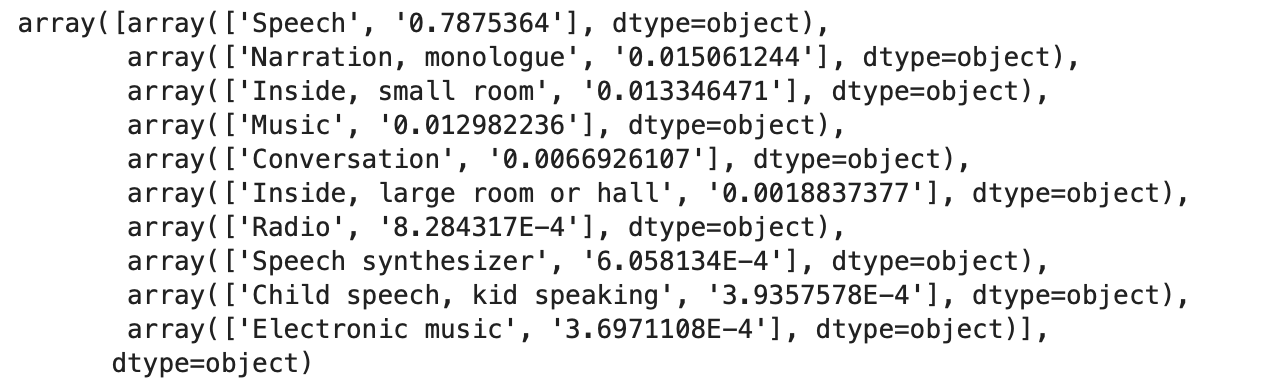
- 예시를 보면 첫 번째 리스트의 사운드 종류일 확률이 0.78로 제일 높다



In [3]:
file_name = "ch2024_test_m_ambience.parquet.gzip"
df_mamb = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))
df_mamb.info()


a = df_mamb['ambience_labels']
lists =[]
for i in a: # 제일 확률이 높은 사운드만 따로 리스트에 넣어줌
    if (i.size == 0): # 해당 컬럼에 비어있는 리스트도 있어서 이때는 값을 unknown으로 해줌
        lists.append('unknown')
    else:
        lists.append(i[0][0])

#lists

df_mamb['sound_variety'] = lists
new_df_mamb = df_mamb.copy()

new_df_mamb.drop(columns = 'ambience_labels', axis = 1, inplace = True)
# new_df_mamb

# 컬럼에 들어갈 컬럼명들을 중복을 제거하고 정렬하여 넣어줌
unique_list = set(lists)
unique_list = sorted(unique_list) # 271개의 서로 다른 사운드 종류가 읶다


# 기존의 timestamp 컬럼 삭제한다
new_df_mamb['Date'] = pd.to_datetime(df_mamb['timestamp'], format='%Y-%m-%d').dt.date
new_df_mamb.drop(columns = 'timestamp', axis = 1, inplace = True)
#new_df_mamb



sound_count = new_df_mamb.groupby(['subject_id', 'Date'])['sound_variety'].value_counts().unstack(fill_value=0)
# sound_count


sound_count.columns = unique_list
print("sound_counts:")
sound_count = sound_count.reset_index()
sound_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82011 entries, 0 to 82010
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       82011 non-null  int64         
 1   timestamp        82011 non-null  datetime64[us]
 2   ambience_labels  82011 non-null  object        
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 1.9+ MB
sound_counts:


,subject_id,Date,"Accelerating, revving, vroom",Air brake,Air conditioning,"Air horn, truck horn",Aircraft,Alarm,Alarm clock,Animal,...,Whistling,White noise,"Whoosh, swoosh, swish",Wild animals,Wind,Wind chime,Wind noise (microphone),Wood,Writing,Zipper (clothing)
0,5,2023-11-05,0,0,0,3,0,0,0,23,...,0,7,0,2,1,0,0,0,0,0
1,5,2023-11-06,0,0,0,0,0,0,0,14,...,0,8,0,0,0,0,0,0,0,0
2,5,2023-11-07,0,0,0,0,1,0,0,26,...,0,9,0,0,0,0,0,1,0,0
3,5,2023-11-08,0,0,0,0,3,0,0,20,...,0,4,0,0,1,0,1,0,0,0
4,5,2023-11-09,0,1,0,0,0,0,0,35,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,8,2023-11-05,0,0,0,0,1,0,0,11,...,0,10,1,0,0,0,0,0,2,0
111,8,2023-11-06,0,0,0,1,0,0,0,1,...,0,3,1,0,23,0,2,0,2,0
112,8,2023-11-07,0,0,0,0,0,0,0,8,...,0,10,1,0,11,0,0,0,0,0
113,8,2023-11-08,0,0,0,0,0,0,0,2,...,1,0,2,0,6,0,0,0,1,0


## mGps
스마트폰에서 산출된 GPS 좌표 정보(단, 위도 및 경도는 상대 좌표로 변환됨). 5초 간격(1분당 약 12회)으로 측정됨.
> ** 이상한 건 115row가 아니라 113row란 점**. 어떤 날짜가 빠졌는지 확인해봐야 함
- subject_id: 실험 참여자의 식별자
- timestamp
- altitude: 고도
- latitude: 위도
- longitude: 경도
- speed: 속도

In [4]:
# 데이터 불러오기
file_name = "ch2024_test_m_gps.parquet.gzip"
df_mgps = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))

# Date 컬럼 새로 만들고 기존의 timestamp 컬럼 제거
df_mgps['Date'] = pd.to_datetime(df_mgps['timestamp'], format='%Y-%m-%d').dt.date
df_mgps.drop(columns = 'timestamp', axis = 1, inplace = True)

# subject_id, Date로 묶어주고 고도,위도, 경도, 속도의 하루치 평균을 구해준다
df_mgps_new = df_mgps.groupby(['subject_id', 'Date'])[['altitude', 'latitude', 'longitude', 'speed']].mean().reset_index()
df_mgps_new

,subject_id,Date,altitude,latitude,longitude,speed
0,5,2023-11-05,87.813200,0.039170,0.026459,0.259230
1,5,2023-11-06,85.885171,0.038824,0.020714,0.240083
2,5,2023-11-07,88.421733,0.038479,0.026345,0.312071
3,5,2023-11-08,81.364382,0.038834,0.020753,0.227484
4,5,2023-11-09,81.076660,0.038763,0.020995,0.236737
...,...,...,...,...,...,...
108,8,2023-11-05,138.407453,1.594410,0.929471,0.526141
109,8,2023-11-06,122.976562,1.599110,0.930586,0.619482
110,8,2023-11-07,135.362709,1.598550,0.927231,0.653059
111,8,2023-11-08,126.958441,1.587734,0.935604,0.420229


## mLight(완)
스마트폰에서 측정된 빛의 세기. 10분 간격으로 측정됨.
> **119 rows로 이상한 4 개가 추가되었다..**
- subject_id: 실험 참여자의 식별자
- timestamp
- m_light: 빛의 세기

In [5]:
# 데이터 불러오기
file_name = "ch2024_test_m_light.parquet.gzip"
df_mlight = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))

# Date 컬럼 새로 만들고 기존의 timestamp 컬럼 제거
df_mlight['Date'] = pd.to_datetime(df_mlight['timestamp'], format='%Y-%m-%d').dt.date
df_mlight.drop(columns = 'timestamp', axis = 1, inplace = True)


# subject_id, Date로 묶어주고 m_light의 하루치  평균을 구해준다
df_mlight_new = df_mlight.groupby(['subject_id', 'Date'])['m_light'].mean().reset_index()
df_mlight_new



,subject_id,Date,m_light
0,5,2023-11-05,30.609929
1,5,2023-11-06,175.140845
2,5,2023-11-07,37.856164
3,5,2023-11-08,67.604317
4,5,2023-11-09,70.743056
...,...,...,...
114,8,2023-11-05,76.743056
115,8,2023-11-06,270.379562
116,8,2023-11-07,94.021898
117,8,2023-11-08,89.531469


## wHr
스마트워치(갤럭시 워치)에서 측정된 심박 데이터. 1초 간격으로 측정됨.
> **105 rows로 합치는 것 성공**
- subject_id: 실험 참여자의 식별자
- timestamp
- heart_rate

In [6]:
# 데이터 불러오기
file_name = "ch2024_test_w_heart_rate.parquet.gzip"
df_wHr = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))

# Date 컬럼 새로 만들고 기존의 timestamp 컬럼 제거
df_wHr['Date'] = pd.to_datetime(df_wHr['timestamp'], format='%Y-%m-%d').dt.date
df_wHr.drop(columns = 'timestamp', axis = 1, inplace = True)

# subject_id, Date로 묶어주고 wHr의 하루치  평균을 구해준다
df_wHr_new = df_wHr.groupby(['subject_id', 'Date'])['heart_rate'].mean().reset_index()
df_wHr_new


,subject_id,Date,heart_rate
0,5,2023-11-05,51.924342
1,5,2023-11-06,55.848824
2,5,2023-11-07,64.660832
3,5,2023-11-08,95.184109
4,5,2023-11-09,90.054438
...,...,...,...
110,8,2023-11-05,83.390303
111,8,2023-11-06,52.962963
112,8,2023-11-07,63.557196
113,8,2023-11-08,58.965463


## wPedo
스마트워치(갤럭시 워치)에서 측정된 걸음수 데이터 및 관련 정보. 1분 간격으로 측정됨.
> **105 rows × 8 columns로 합치기 성공**

- subject_id: 실험 참여자의 식별자
- timestamp
- burned_calories: 소모된 칼로리(하루 총량)
- distance: 이동거리(하루 총량)
- running_steps: 뛰어간 걸음 수(하루 총량)
- speed: 속도(평균)
- steps: 분당 걸음 수(평균)
- step_frequency: 걸음 발생 주기(평균)

In [7]:
# 데이터 불러오기
file_name = "ch2024_test_w_pedo.parquet.gzip"
df_wPedo = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))


# Date 컬럼 새로 만들고 기존의 timestamp 컬럼 제거
df_wPedo['Date'] = pd.to_datetime(df_wPedo['timestamp'], format='%Y-%m-%d').dt.date
df_wPedo.drop(columns = 'timestamp', axis = 1, inplace = True)



df_wPedo_new = df_wPedo.groupby(['subject_id', 'Date'])[['speed', 'steps', 'step_frequency']].mean().reset_index()
df_wPedo_new2 = df_wPedo.groupby(['subject_id', 'Date'])[['burned_calories', 'distance', 'running_steps']].sum().reset_index()
df_wPedo_final = pd.concat([df_wPedo_new, df_wPedo_new2.loc[:, 'burned_calories':]], axis=1)
df_wPedo_final


,subject_id,Date,speed,steps,step_frequency,burned_calories,distance,running_steps
0,5,2023-11-05,0.063315,5.110774,0.085180,481.047056,5006.964180,0
1,5,2023-11-06,0.092873,7.480972,0.124683,671.767746,6881.904678,0
2,5,2023-11-07,0.078365,6.244477,0.104075,468.117453,6385.201452,0
3,5,2023-11-08,0.135728,10.819415,0.180324,532.178798,7801.622101,0
4,5,2023-11-09,0.257226,20.531532,0.342192,471.791389,8565.634766,0
...,...,...,...,...,...,...,...,...
110,8,2023-11-05,0.106132,1.194927,0.019915,47.260509,695.219658,8
111,8,2023-11-06,0.669138,9.398403,0.156640,564.691689,9963.401878,177
112,8,2023-11-07,0.063199,0.260550,0.004343,151.019085,386.870533,7
113,8,2023-11-08,0.350886,4.779424,0.079657,252.616329,4457.157587,30


## wLight
- 스마트워치(갤럭시 워치)에서 빛의 세기. 10분 간격으로 측정됨.
- subject_id: 실험 참여자의 식별자
- timestamp
- w_light: 빛의 세기

In [8]:
# 데이터 불러오기
file_name = "ch2024_test_w_light.parquet.gzip"
df_wLight = pd.read_parquet(os.path.join(challenge2024_dataset_path2, file_name))


# Date 컬럼 새로 만들고 기존의 timestamp 컬럼 제거
df_wLight['Date'] = pd.to_datetime(df_wLight['timestamp'], format='%Y-%m-%d').dt.date
df_wLight.drop(columns = 'timestamp', axis = 1, inplace = True)

# subject_id, Date로 묶어주고 m_light의 하루치  평균을 구해준다
df_wLight_new = df_wLight.groupby(['subject_id', 'Date'])['w_light'].mean().reset_index()
df_wLight_new


,subject_id,Date,w_light
0,5,2023-11-05,38.008065
1,5,2023-11-06,371.309524
2,5,2023-11-07,24.870229
3,5,2023-11-08,155.833333
4,5,2023-11-09,151.011236
...,...,...,...
110,8,2023-11-05,17.609756
111,8,2023-11-06,5.965035
112,8,2023-11-07,7.380282
113,8,2023-11-08,10.853147


## gps에 빠진 2개의 row를 알아보자
**50, 67에 gps관련 정보가 nan**


In [9]:
missing_value = df_mact_fin.merge(df_mgps_new, on=['subject_id', 'Date'], how='left') # macc, wlight
missing_value
nan_rows = missing_value[missing_value.isna().any(axis=1)]
nan_rows # 55, 79, 83, 84 row에 gps관련 정보가 nan 

,subject_id,Date,m_activity,IN_VEHICLE,ON_BICYCLE,STILL,UNKNOWN,WALKING,RUNNING,altitude,latitude,longitude,speed
50,6,2023-11-05,1402,35,52,832,6,469,8,NaN,NaN,NaN,NaN
67,7,2023-11-18,1437,41,0,1199,185,12,0,NaN,NaN,NaN,NaN


In [10]:
total = df_mact_fin.merge(df_wLight_new, on=['subject_id', 'Date'], how='inner') # macc, wlight
total = total.merge(df_wHr_new, on=['subject_id', 'Date'], how='inner') # df_wHr_new
total = total.merge(df_wPedo_final, on=['subject_id', 'Date'], how='inner') # df_wPedo_final
total = total.merge(df_mlight_new, on=['subject_id', 'Date'], how='inner') # df_mlight_new
total = total.merge(df_mgps_new, on=['subject_id', 'Date'], how='left') # df_mgps_new
total = total.merge(sound_count, on=['subject_id', 'Date'], how='left') # df_mgps_new
total

,subject_id,Date,m_activity,IN_VEHICLE,ON_BICYCLE,STILL,UNKNOWN,WALKING,RUNNING,w_light,...,Whistling,White noise,"Whoosh, swoosh, swish",Wild animals,Wind,Wind chime,Wind noise (microphone),Wood,Writing,Zipper (clothing)
0,5,2023-11-05,1434,122,3,843,396,70,0,38.008065,...,0,7,0,2,1,0,0,0,0,0
1,5,2023-11-06,1440,98,0,1279,0,56,7,371.309524,...,0,8,0,0,0,0,0,0,0,0
2,5,2023-11-07,1440,64,0,1345,0,31,0,24.870229,...,0,9,0,0,0,0,0,1,0,0
3,5,2023-11-08,1435,19,0,540,845,31,0,155.833333,...,0,4,0,0,1,0,1,0,0,0
4,5,2023-11-09,1440,48,0,1379,0,12,1,151.011236,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,8,2023-11-05,1440,18,0,1418,0,4,0,17.609756,...,0,10,1,0,0,0,0,0,2,0
111,8,2023-11-06,1432,86,0,1130,1,215,0,5.965035,...,0,3,1,0,23,0,2,0,2,0
112,8,2023-11-07,1431,108,0,1288,0,34,1,7.380282,...,0,10,1,0,11,0,0,0,0,0
113,8,2023-11-08,1437,9,0,1218,69,141,0,10.853147,...,1,0,2,0,6,0,0,0,1,0


In [11]:
total.to_csv("/Users/aswm0121/Downloads/test_total.csv")